In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0,1,2'

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
import cv2

import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
% matplotlib inline
import glob

/home/xavierc/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
dsb_data_dir = '/media/disk2/dataset-kaggle/2018_DSB/'

In [5]:
train_labels = pd.read_csv(dsb_data_dir+'stage1_train_labels.csv')
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
15296,7c318172e976ae5a962c9c7a4e9fe46d7fb985765ddd3a...,"[51222, 3, 51477, 5, 51733, 5, 51989, 5, 52246..."
20473,aaa52100fafaa50877e777229cdf6cde7c422f145ff671...,"[95795, 6, 96314, 12, 96833, 15, 97352, 17, 97..."
11536,5d2c98fd6fda3c7d739461c3b3d4a0c7f8456121a14519...,"[49802, 6, 50057, 8, 50312, 10, 50567, 12, 508..."


In [6]:
train_labels.ImageId[0]

'00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'

In [7]:
all_images = glob.glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
all_images[:3]

['/media/disk2/dataset-kaggle/2018_DSB/stage1_train/bc115ff727e997a88f7cfe4ce817745731a6c753cb9fab6a36e7e66b415a1d3d/masks/91c1e7ee69bb7b59fa6e995d5bd38f380e4bc4153ad120acfcc38460be68ac48.png',
 '/media/disk2/dataset-kaggle/2018_DSB/stage1_train/bc115ff727e997a88f7cfe4ce817745731a6c753cb9fab6a36e7e66b415a1d3d/masks/fcc9cb188cb0fb383a2df9594cdb71a0716677b01c92bde24aa59453ee68dfe0.png',
 '/media/disk2/dataset-kaggle/2018_DSB/stage1_train/bc115ff727e997a88f7cfe4ce817745731a6c753cb9fab6a36e7e66b415a1d3d/masks/0167c7ad8784cc80a0f41d0eeb2a46a901bb7242235da2745d6f8aeb80f01e58.png']

In [8]:
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(3)

,path,ImageId,ImageType,TrainingSplit,Stage
22682,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,ead9464a50a17f74bf1b6471d94ecce8d887cf518c8fed...,masks,train,stage1
17623,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,dad607a203483439fcbc2acecd0a39fb5e5a94a32a9434...,masks,train,stage1
11664,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,c96109cbebcf206f20035cbde414e43872074eee8d839b...,masks,train,stage1


In [9]:
# img_df[img_df.TrainingSplit=='test']

In [10]:
from skimage.io import imread

In [11]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['mask_path'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['img_path'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['imgrle'] = train_img_df['img_path'].map(read_and_stack)
train_img_df['maskrle'] = train_img_df['mask_path'].map(read_and_stack).map(lambda x: x.astype(int))

train_img_df.head()

CPU times: user 41 s, sys: 3.53 s, total: 44.5 s
Wall time: 44.5 s


In [12]:
train_img_df['img_path'] = train_img_df['img_path'].apply(lambda x: x[0])
train_img_df['mask_path'] = train_img_df['mask_path'].apply(lambda x: x[0])
train_img_df.head()

,ImageId,Stage,img_path,mask_path,imgrle,maskrle
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,stage1,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,"[[[0.0196078431372549, 0.0196078431372549, 0.0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,003cee89357d9fe13516167fd67b609a164651b2193458...,stage1,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,"[[[0.0196078431372549, 0.0196078431372549, 0.0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,stage1,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,"[[[0.5098039215686274, 0.24313725490196078, 0....","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,..."
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,stage1,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,"[[[0.7019607843137254, 0.6235294117647059, 0.7...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,stage1,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,"[[[0.6784313725490196, 0.615686274509804, 0.76...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [13]:
train_img_df.img_path.iloc[0]

'/media/disk2/dataset-kaggle/2018_DSB/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png'

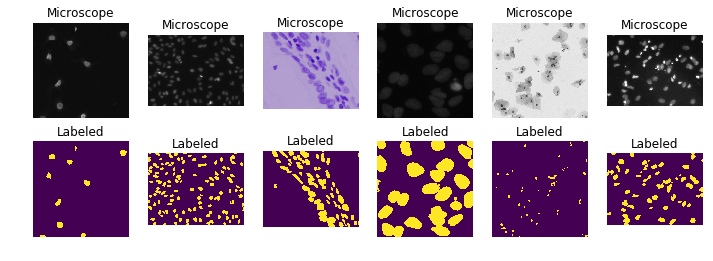

In [14]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['imgrle'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['maskrle'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

In [15]:
train_img_df['imgrle'].map(lambda x: x.shape).value_counts()

(256, 256, 4)      334
(256, 320, 4)      112
(520, 696, 4)       92
(360, 360, 4)       91
(1024, 1024, 4)     16
(512, 640, 4)       13
(603, 1272, 4)       6
(260, 347, 4)        5
(1040, 1388, 4)      1
Name: imgrle, dtype: int64

In [16]:
train_img_df.shape

(670, 6)

In [17]:
test_df = img_df.query('TrainingSplit=="test"')

test_rows = []
group_cols = ['Stage', 'ImageId']


for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
#     c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['img_path'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows) 

In [18]:
%%time

def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
test_img_df['imgrle'] = test_img_df['img_path'].map(read_and_stack)
test_img_df['img_path'] = test_img_df['img_path'].apply(lambda x: x[0])
# test_img_df['masks'] = test_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
test_img_df.sample(1)

CPU times: user 744 ms, sys: 8 ms, total: 752 ms
Wall time: 748 ms


In [19]:
test_img_df['imgrle'].map(lambda x: x.shape).value_counts()

(256, 256, 4)    20
(512, 640, 4)     8
(512, 680, 3)     8
(256, 256, 3)     4
(519, 253, 3)     4
(520, 348, 3)     4
(260, 347, 4)     4
(520, 696, 4)     4
(524, 348, 3)     4
(519, 161, 3)     2
(519, 162, 3)     2
(390, 239, 4)     1
Name: imgrle, dtype: int64

In [20]:
train_img_df.img_path.iloc[0]

'/media/disk2/dataset-kaggle/2018_DSB/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png'

In [21]:
train_img_df.mask_path.iloc[0]

'/media/disk2/dataset-kaggle/2018_DSB/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/b6fc3b5403de8f393ca368553566eaf03d5c07148539bc6141a486f1d185f677.png'

In [22]:
img1 = cv2.imread(train_img_df.img_path.iloc[0])
mask1 = train_img_df.maskrle.iloc[0]

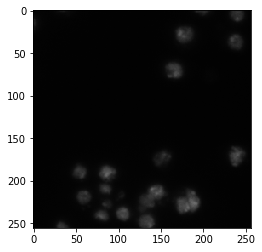

In [23]:
plt.imshow(img1)

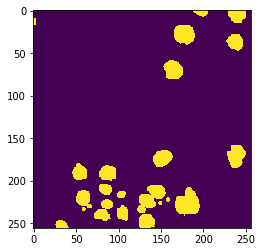

In [24]:
plt.imshow(mask1)

In [25]:
mask1.max()

1

In [26]:
def dice_metric(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coeff_hard(y_true, y_pred): 
    smooth = 1. 
    y_true_f = K.flatten(y_true) 
    y_pred_f = K.round(K.flatten(y_pred)) 
    intersection = K.sum(y_true_f * y_pred_f) 
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth) 
    return score




def dice_metric_true(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    return y_true_f

def dice_metric_pred(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    return y_pred_f

def dice_metric_intersection(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def focus_loss(y_true,y_pred):
    gamma = .01
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    loss = y_true*K.log(y_pred+K.epsilon())*(1-y_pred+K.epsilon())**gamma + (1-y_true)*K.log(1-y_pred+K.epsilon())*(y_pred+K.epsilon())**gamma
    return (-K.sum(loss))



def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_focus_loss_coef(y_true, y_pred):
    return jacard_coef_loss(y_true, y_pred)+ focus_loss(y_true,y_pred)



def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)



def dice_jacard_loss(y_true, y_pred):
    return jacard_coef_loss(y_true, y_pred) + (1 - dice_metric(y_true, y_pred))


def dice_jacard_binary_loss(y_true, y_pred):
    return jacard_coef_loss(y_true, y_pred) + (1 - dice_metric(y_true, y_pred))*.2 + binary_crossentropy(y_true, y_pred)*.05


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) +  jacard_coef_loss(y_true, y_pred)






def weighted_jaccard_coeff_orig(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = -(K.sum(w * intersection) + 1.) / (K.sum(w * m1) + K.sum(w * m2) - K.sum(w * intersection)+1 )
    #(intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
    return score

def weighted_dice_coeff_orig(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return score




In [62]:


from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, AveragePooling2D
from keras.optimizers import RMSprop
from keras.layers.convolutional import Cropping2D
from keras.utils.training_utils import multi_gpu_model



from keras.layers.advanced_activations import LeakyReLU, PReLU

def get_unet_tf_1280x1280_sp2_crop(input_shape=(1408, 1408, 3),
                  num_classes=1):
    inputs = Input(shape=input_shape)
    1024

    down0b = Conv2D(8, (3, 3), padding='same')(inputs)
    down0b = BatchNormalization()(down0b)
    down0b = Activation('relu')(down0b)
    down0b = Conv2D(8, (3, 3), padding='same')(down0b)
    down0b = BatchNormalization()(down0b)
    down0b = Activation('relu')(down0b)
    down0b_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0b)
    512

    down0a = Conv2D(16, (3, 3), padding='same')(down0b_pool)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a = Conv2D(16, (3, 3), padding='same')(down0a)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0a)
    # 256

    down0 = Conv2D(32, (3, 3), padding='same')(down0a_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    # 256

    up0a = UpSampling2D((2, 2))(up0)
    up0a = concatenate([down0a, up0a], axis=3)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
#     up0a = Cropping2D(cropping=((64,64),(64,64)))(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    # 512

    up0b = UpSampling2D((2, 2))(up0a)
    up0b = concatenate([down0b, up0b], axis=3)
    up0b = Conv2D(8, (3, 3), padding='same')(up0b)
    up0b = BatchNormalization()(up0b)
    up0b = Activation('relu')(up0b)
    up0b = Conv2D(8, (3, 3), padding='same')(up0b)
    up0b = BatchNormalization()(up0b)
    up0b = Activation('relu')(up0b)
    up0b = Conv2D(8, (3, 3), padding='same')(up0b)
    up0b = Cropping2D(cropping=((64,64),(64,64)))(up0b)
    up0b = BatchNormalization()(up0b)
    up0b = Activation('relu')(up0b) ##### change for elu
    # 1024

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0b)

    model = Model(inputs=inputs, outputs=classify)
#     model = multi_gpu_model(model, gpus=3)

    model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=[dice_metric])
    
    #jacard_coef_loss weighted_jacard_loss_orig dice_jacard_binary_loss

    return model

In [28]:
128*5

640

In [63]:
# from model.u_net import get_unet_128, get_unet_tf_1280x1280_sp2_crop, get_unet_512, get_unet_1024, get_unet_tf_1536x1024_crop \
#                         ,get_tiram, get_unet_1024_usv, get_unet_tf_1152x1152_usv_crop, get_unet_tf_1280x1280_usv_crop

#input_size = (1536,1024)
input_size = (512, 512)

max_epochs = 100
batch_size = 3

# orig_width = 1918
# orig_height = 1280

threshold = 0.5

#model = get_unet_tf_1536x1024_crop()


model = get_unet_tf_1280x1280_sp2_crop((640, 640,  4))

NameError: name 'K' is not defined

In [30]:
#(None, 1152, 2048, 4) 0 
# (None, 1920, 1152, 1) 9 

In [31]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 640, 640, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 640, 640, 8)  296         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 640, 640, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 640, 640, 8)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [32]:

input_size_w = int(input_size[0])
input_size_h = int(input_size[1])
epochs = max_epochs

print(input_size_w,input_size_h)

512 512


In [33]:
df_train = train_img_df

In [34]:
df_train.shape

(670, 6)

In [35]:
len(df_train), len(df_train)*.8

(670, 536.0)

In [36]:
trn_data = df_train[536:] #############################
val_data = df_train[:536]

print('Training on {} samples'.format(len(trn_data)))
print('Validating on {} samples'.format(len(val_data)))

Training on 134 samples
Validating on 536 samples


In [37]:
df_train.columns

Index(['ImageId', 'Stage', 'img_path', 'mask_path', 'imgrle', 'maskrle'], dtype='object')

In [38]:
trn_data.head()

,ImageId,Stage,img_path,mask_path,imgrle,maskrle
536,c9f305be17312bdb9530fb4f1adc6d29730ddbe0e74730...,stage1,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,"[[[0.027450980392156862, 0.027450980392156862,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
537,cab4875269f44a701c5e58190a1d2f6fcb577ea79d8425...,stage1,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,"[[[0.00784313725490196, 0.00784313725490196, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
538,cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3...,stage1,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
539,cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9...,stage1,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,"[[[0.6941176470588235, 0.6235294117647059, 0.8...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
540,cbff60361ded0570e5d50429a1aa51d81471819bc9b383...,stage1,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,/media/disk2/dataset-kaggle/2018_DSB/stage1_tr...,"[[[0.403921568627451, 0.14901960784313725, 0.7...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [39]:

def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image


def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape
        
        add_height = int(height / 3)
        add_width = int(width / 3)
        image = cv2.copyMakeBorder(image,add_height,add_height,add_width,add_width,cv2.BORDER_REFLECT_101) #top, bottom, left, right 
        mask = cv2.copyMakeBorder(mask,add_height,add_height,add_width,add_width,cv2.BORDER_REFLECT_101) #top, bottom, left, right 
        height, width, channel = image.shape
        
        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])*1.0  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        image = image[add_height:-add_height,add_width:-add_width,:]
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))
        mask = mask[add_height:-add_height,add_width:-add_width]

    return image, mask


def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
#     if np.random.random() < u:
#         image = cv2.flip(image, 2)
#         mask = cv2.flip(mask, 2)
#     if np.random.random() < u:
#         image = np.rot90(image,1)
#         mask = np.rot90(mask,1)
#     if np.random.random() < u:
#         image = np.rot90(image,2)
#         mask = np.rot90(mask,2)
    return image, mask



def mask_jitter(mask):
    w,h = mask.shape
    v1 = np.random.randint(-1,2)

    if v1 ==-1:
        mask = cv2.copyMakeBorder(mask,1,0,0,0,cv2.BORDER_REFLECT_101)
        mask = mask[:w,:]

    if v1 ==1:
        mask = cv2.copyMakeBorder(mask,0,1,0,0,cv2.BORDER_REFLECT_101)
        mask = mask[1:,:]

        
    v2 = np.random.randint(-1,2)
    if v2 ==-1:
        mask = cv2.copyMakeBorder(mask,0,0,1,0,cv2.BORDER_REFLECT_101)
        mask = mask[:,:h]

    if v2==1:
        mask = cv2.copyMakeBorder(mask,0,0,0,1,cv2.BORDER_REFLECT_101)
        mask = mask[:,1:]

    return mask


# from dehaze import DarkChannel, AtmLight, TransmissionEstimate, TransmissionRefine, Recover

# def dehaze_img(img):
#     I = img.astype('float64')/255.;

#     dark = DarkChannel(I,15);
#     A = AtmLight(I,dark);
#     te = TransmissionEstimate(I,A,15);
#     t = TransmissionRefine(img,te);
#     J = Recover(I,t,A,0.1);
#     return np.array(J*255.)



In [40]:
def rle_decode(mask_rle, shape=(1280,1918)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [41]:
img = imread(trn_data.img_path.iloc[0])
img.shape

(360, 360, 4)

In [64]:
def train_generator(data, batch_size):

    while 1:
        x_batch = []
        y_batch = []
        
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            
            img = imread(data.img_path.iloc[i_line])  ### opencv only open 3 layers instead of 4
#             img = cv2.copyMakeBorder(img,0,0,0,0,cv2.BORDER_REFLECT_101)
#             img = img[64:-64,:,:]
#             img = cv2.fastNlMeansDenoisingColored(img,None,5,5,5,5)
            img = cv2.resize(img, (input_size_w, input_size_h))#,cv2.INTER_AREA)
            img = cv2.copyMakeBorder(img,64,64,64,64,cv2.BORDER_REFLECT_101) #top, bottom, left, right;
    
            
            mask = data.maskrle.iloc[i_line].astype(np.uint8)
            mask = cv2.resize(mask, (input_size_w, input_size_h))# ,cv2.INTER_AREA)
# #             mask_rle = data.rle_mask.iloc[i_line]
# #             mask = rle_decode(mask_rle)
# #             mask = mask[64:-64,:]
#             mask = cv2.copyMakeBorder(mask,0,0,0,0,cv2.BORDER_REFLECT_101)
# #           
            if mask.max() <=1:
                mask[mask<.5]=0                        ##### A REVOIR !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!########
                mask[mask>=.5]=255
#                 mask = mask*255
            
#             mask = cv2.copyMakeBorder(mask,32,32,32,32,cv2.BORDER_REFLECT_101)
            
#             img = randomHueSaturationValue(img,
#                                            hue_shift_limit=(-10, 10),
#                                            sat_shift_limit=(-10, 10),
#                                            val_shift_limit=(-10, 10))
            
#             img, mask = randomShiftScaleRotate(img, mask,
#                                                shift_limit=(-0.03, 0.03),
#                                                scale_limit=(-0.01, 0.01),
#                                                rotate_limit=(0,0))
            
#             imgdeh = DarkChannel(img,9)
    
            #### concatenate img and usv in a 4D tensor
#             img = np.dstack((img, usv)) 
            
            
#             img, mask = randomHorizontalFlip(img, mask)
            
#             mask = mask[32:-32,32:-32]
#             mask = mask_jitter(mask)
            mask = np.expand_dims(mask, axis=2)

            
            x_batch.append(img)
            y_batch.append(mask)
            #print(mask.shape, mask) 
        x_batch = np.array(x_batch, np.float32) /255. - .5
        y_batch = np.array(y_batch, np.float32) / 255
        #x_batch = x_batch.transpose((0,3,1,2))
        #y_batch = y_batch.transpose((0,3,1,2))
        yield x_batch, y_batch


# def valid_generator(data):
    
#     while 1:
#         x_batch = []
#         y_batch = []
        
#         for i_batch in range(batch_size):
#             i_line = np.random.randint(len(data))
            
#             img = cv2.imread(data.img_path.iloc[i_line])
#             img = cv2.copyMakeBorder(img,0,0,1,1,cv2.BORDER_REFLECT_101)
#             img = img[64:-64,:,:]
# #             img = cv2.fastNlMeansDenoisingColored(img,None,5,5,5,5)
# #             img = cv2.resize(img, (input_size_w, input_size_h))#,cv2.INTER_AREA)
#             img = cv2.copyMakeBorder(img,0,0,64,64,cv2.BORDER_REFLECT_101)
        
            
# #             imgdeh = DarkChannel(img,9)
# #             img = randomHueSaturationValue(img,
# #                                            hue_shift_limit=(-25, 25),
# #                                            sat_shift_limit=(-5, 5),
# #                                            val_shift_limit=(-5, 5))
            
#             img = np.dstack((img, usv))
            
# #             mask = cv2.imread(data.mask_path.iloc[i_line], cv2.IMREAD_GRAYSCALE)
#             mask_rle = data.rle_mask.iloc[i_line]
#             mask = rle_decode(mask_rle)
#             mask = cv2.copyMakeBorder(mask,0,0,1,1,cv2.BORDER_REFLECT_101)
#             mask = mask[64:-64,:]
# #             mask = cv2.resize(mask, (input_size_w, input_size_h))# ,cv2.INTER_AREA)
#             if mask.max() <=1:
#                 mask[mask<.5]=0
#                 mask[mask>=.5]=255
            
# #             mask = cv2.copyMakeBorder(mask,32,32,32,32,cv2.BORDER_REFLECT_101)
            
# #             mask = mask[32:-32,32:-32]
            
#             mask = np.expand_dims(mask, axis=2)
# #             img = dehaze_img(img)

#             x_batch.append(img)
#             y_batch.append(mask)
        
#         x_batch = np.array(x_batch, np.float32) /255. - .5
#         y_batch = np.array(y_batch, np.float32) / 255
#         #x_batch = x_batch.transpose((0,3,1,2))
#         #y_batch = y_batch.transpose((0,3,1,2))
#         yield x_batch, y_batch

In [65]:
def trn_gen_mix(data, batch_size=3, prop=0.67):   #### train generator for unbalanced data

    n1 = int(batch_size*prop)
#     print n1
    n2 = batch_size - n1
#     print n2
    sg1 = train_generator(trn_data, n1)
    sg2 = train_generator(df_train_wg, n2)
    while True:
        out1 = sg1.next()
        out2 = sg2.next()
        if out2 is None:
            yield out1
        else:
#             print out1[0].shape, out2[0].shape
            yield np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1]))

In [66]:
e, f = next(train_generator(trn_data, 2))
e.shape, f.shape

((2, 640, 640, 4), (2, 512, 512, 1))

In [67]:
np.histogram(f)

(array([482371,      0,      0,      0,      0,      0,      0,      0,
             0,  41917]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [69]:
plt.figure(figsize=(12,12))
plt.imshow(e[0][:,:,:3]*255)

ValueError: Floating point image RGB values must be in the 0..1 range.

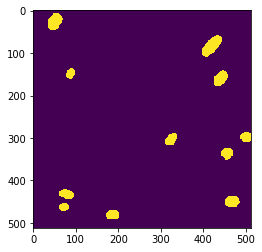

In [70]:
plt.imshow(f[0].reshape(f[0].shape[0],f[0].shape[0]))

In [48]:
# e, f = next(train_generator(df_test, 1))
# e.shape, f.shape

In [193]:
# img, mask = next(trn_gen_mix(trn_data))
# img.shape, mask.shape

In [51]:
df_train.img_path.iloc[4]

'/media/disk2/dataset-kaggle/2018_DSB/stage1_train/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf/images/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf.png'

In [59]:
np.array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [52]:

callbacks = [EarlyStopping(monitor='val_dice_metric',
                           patience=6,
                           verbose=1,
                           min_delta=1e-4,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_dice_metric',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_metric',
                             filepath=dsb_data_dir + 'best_weights_1280x1280_unet_tf_usv_crop.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max'),
             TensorBoard(log_dir='logs')]

#model.summary()

# model.load_weights(dsb_data_dir + 'best_weights_1280x1280_unet_tf_usv_crop_t0053b_mod001001_9947_001.hdf5')


In [53]:
# next(train_generator(val_data, batch_size))

In [54]:
len(trn_data)

134

In [55]:
np.ceil(float(len(val_data)) / float(batch_size))

179.0

In [56]:
batch_size=8

In [61]:
from keras.optimizers import RMSprop, Adam
# from model.losses import bce_dice_loss

# model.loss = bce_dice_loss
model.optimizer=Adam(lr=1e-7, decay=5e-8)#, accumulator=10) ##### #####

model.fit_generator(generator=train_generator(trn_data, batch_size),
                    steps_per_epoch=np.ceil(float(len(trn_data)) / float(batch_size)),#######
                    epochs=10,
                    verbose=1,
#                     callbacks=callbacks,
                    validation_data=train_generator(val_data, batch_size),
                    validation_steps=np.ceil(float(len(val_data)) / float(batch_size)))

Epoch 1/10
17/17 [==============================] - 23s 1s/step - loss: 0.3579 - val_loss: 0.9646
Epoch 2/10
16/17 [===========================>..] - ETA: 0s - loss: 0.3429

KeyboardInterrupt: 

In [76]:
model.save_weights('/home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/weights/best_weights_1280x1280_unet_tf_usv_crop_t0053b_mod001001_9973_002_jac1dic.2bc.05.hdf5')


In [49]:
# Epoch 00012: reducing learning rate to 9.99999974738e-07.
# 1018/1018 [==============================] - 1292s - loss: -0.9937 - dice_metric: 0.9968 - val_loss: -0.9936 - val_dice_metric: 0.9968
# Epoch 00012: early stopping

In [1]:
np.linspace(.5, 0.95, np.round((0.95 - .5) / .05) + 1, endpoint=True)

NameError: name 'np' is not defined

In [54]:
100000/1000.*6/60.

10.0

In [1]:
# simple fold -- submit generator

In [51]:
# weights_path = '/home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/weights/'

# model1 = get_unet_tf_1280x1280_usv_crop()
# model1.load_weights(weights_path+'.hdf5')
# model2 = get_unet_tf_1280x1280_usv_crop()
# model2.load_weights(weights_path+'.hdf5')
# model3 = get_unet_tf_1280x1280_usv_crop()
# model3.load_weights(weights_path+'.hdf5')
# model4 = get_unet_tf_1280x1280_usv_crop()
# model4.load_weights(weights_path+'.hdf5')
# model5 = get_unet_tf_1280x1280_usv_crop()
# model5.load_weights(weights_path+'.hdf5')

In [53]:
import threading

In [54]:

### simple without augmentation


import threading
import multiprocessing as queue
import tensorflow as tf
from tqdm import tqdm




batch_size = 3

weight_path = '/home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/weights/'

print('load test sub file...')
df_test = pd.read_csv('/opt/datasets/kaggle/Carvana/sample_submission.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))


# https://www.kaggle.com/stainsby/fast-tested-rle
def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    inds[0] = 0
    inds[-1] = 0
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle

# model.load_weights('/home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/weights/best_weights_1280x1280_unet_tf_usv_crop_t0053b.hdf5')

rles = []

print('load model weights...')

# model.load_weights(filepath=weight_path + 'best_weights_1280x1280_unet_tf_usv_crop_t0053b.hdf5')
graph = tf.get_default_graph()

print('model is ready...')

q_size = 10


def data_loader(q, ):
    for start in range(0, len(ids_test), batch_size):
        x_batch = []
        index_batch = []
        end = min(start + batch_size, len(ids_test))
        ids_test_batch = ids_test[start:end]
        ids_test_list = ids_test_batch.values.tolist()
        ll=0
        for id in ids_test_batch.values:
            
            img_path = '/opt/datasets/kaggle/Carvana/test_hq/test_hq/{}.jpg'.format(id)
            usv_path = '/opt/datasets/kaggle/Carvana/backgdusv2/{}.png'.format(id)
            
            img = cv2.imread(img_path)
            img = cv2.copyMakeBorder(img,0,0,1,1,cv2.BORDER_REFLECT_101)
            img = img[64:-64,:,:]
#             img = cv2.fastNlMeansDenoisingColored(img,None,5,5,5,5)
#             img = cv2.resize(img, (input_size_w, input_size_h),cv2.INTER_AREA)
            
            img = cv2.copyMakeBorder(img,0,0,64,64,cv2.BORDER_REFLECT_101)
        
            usv = cv2.imread(usv_path, cv2.IMREAD_GRAYSCALE)
            usv = cv2.copyMakeBorder(usv,0,0,1,1,cv2.BORDER_REFLECT_101)
            usv = usv[64:-64,:]
#             usv = cv2.resize(usv, (input_size_w, input_size_h),cv2.INTER_AREA)
            
            usv = cv2.copyMakeBorder(usv,0,0,64,64,cv2.BORDER_REFLECT_101)
            
            img1 = np.dstack((img, usv))
            
            x_batch.append(img1)
            
#             img = randomHueSaturationValue(img,
#                                hue_shift_limit=(-25, 25),
#                                sat_shift_limit=(-5, 5),
#                                val_shift_limit=(-5, 5))
#             img2 = np.dstack((img, usv))
#             x_batch.append(img2)
            
            
            ll= ll+1
            
        x_batch = np.array(x_batch, np.float32) /255. - .5
        q.put((x_batch, ids_test_list))


def predictor(q, ):
    for i in tqdm(range(0, len(ids_test), batch_size)):
        x_batch, index_batch = q.get()
#         print index_batch, index_batch.shape
        with graph.as_default():
#             preds1 = model1.predict(x_batch, batch_size=batch_size)
#             preds2 = model2.predict(x_batch, batch_size=batch_size)
#             preds3 = model3.predict(x_batch, batch_size=batch_size)
#             preds4 = model4.predict(x_batch, batch_size=batch_size)
#             preds5 = model5.predict(x_batch, batch_size=batch_size)
#             preds = (preds1 + preds2 + preds3 + preds4 + preds5)/5.
            preds = model.predict(x_batch, batch_size=batch_size)
        preds = np.squeeze(preds, axis=3)
        ll=0
        for pred in preds:
            ### ajouter 64 en haut et en bas et resize de 1920 a 1918
            prob = pred[:,1:-1]
#             prob = cv2.resize(pred, (1918, 1152), cv2.INTER_LINEAR)
            mask = prob ##################
            mask = cv2.copyMakeBorder(mask,64,64,0,0,cv2.BORDER_CONSTANT,value=[0,0,0])
            mask_mat = np.array(mask*255,np.uint8)
#             cv2.imwrite('/opt/datasets/kaggle/Carvana/test_masks_prob/'+index_batch[ll]+'_maskprob.png', mask_mat)
            mask[mask<.5]=0
            mask[mask>=.5]=1
#             print(mask.shape)
#             print(mask.shape)
            rle = run_length_encode(mask)
            rles.append(rle)
            ll = ll+1


q = queue.Queue(maxsize=q_size)
t1 = threading.Thread(target=data_loader, name='DataLoader', args=(q,))
t2 = threading.Thread(target=predictor, name='Predictor', args=(q,))
print('Predicting on {} samples with batch_size = {} '.format(len(ids_test), batch_size))
t1.start()
t2.start()
# Wait for both threads to finish
t1.join()
t2.join()

print("Generating submission file...")
df = pd.DataFrame({'img': names, 'rle_mask': rles})
df.to_csv('./submit/submissionbestmod001_fullsizemaskimg_tf_usv_9974_003.csv.gz', index=False, compression='gzip')
print("C'est FINI !!!...")

  0%|          | 0/33355 [00:00<?, ?it/s]

load test sub file...
load model weights...
model is ready...
Predicting on 100064 samples with batch_size = 3 


100%|██████████| 33355/33355 [6:48:55<00:00,  1.12s/it]


Generating submission file...
C'est FINI !!!...


In [51]:

### with augmentation


import threading
import multiprocessing as queue
import tensorflow as tf
from tqdm import tqdm

batch_size = 4

weight_path = '/home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/weights/'

print('load test sub file...')
df_test = pd.read_csv('/opt/datasets/kaggle/Carvana/sample_submission.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))


# https://www.kaggle.com/stainsby/fast-tested-rle
def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle

# model.load_weights('/home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/weights/best_weights_1280x1280_unet_tf_usv_crop_t0053b.hdf5')

rles = []

print('load model weights...')

# model.load_weights(filepath=weight_path + 'best_weights_1280x1280_unet_tf_usv_crop_t0053b.hdf5')
graph = tf.get_default_graph()

print('model is ready...')

q_size = 12


def data_loader(q, ):
    for start in range(0, len(ids_test), batch_size):
        x_batch = []
        index_batch = []
        end = min(start + batch_size, len(ids_test))
        ids_test_batch = ids_test[start:end]
        ids_test_list = ids_test_batch.values.tolist()
        ll=0
        for id in ids_test_batch.values:
            
            img_path = '/opt/datasets/kaggle/Carvana/test_hq/test_hq/{}.jpg'.format(id)
            usv_path = '/opt/datasets/kaggle/Carvana/backgdusv2/{}.png'.format(id)
            
            img = cv2.imread(img_path)
            img = cv2.copyMakeBorder(img,0,0,1,1,cv2.BORDER_REFLECT_101)
            img = img[64:-64,:,:]
#             img = cv2.fastNlMeansDenoisingColored(img,None,5,5,5,5)
#             img = cv2.resize(img, (input_size_w, input_size_h),cv2.INTER_AREA)
            
            img = cv2.copyMakeBorder(img,0,0,64,64,cv2.BORDER_REFLECT_101)
        
            usv = cv2.imread(usv_path, cv2.IMREAD_GRAYSCALE)
            usv = cv2.copyMakeBorder(usv,0,0,1,1,cv2.BORDER_REFLECT_101)
            usv = usv[64:-64,:]
#             usv = cv2.resize(usv, (input_size_w, input_size_h),cv2.INTER_AREA)
            
            usv = cv2.copyMakeBorder(usv,0,0,64,64,cv2.BORDER_REFLECT_101)
            
            img1 = np.dstack((img, usv))
            
            x_batch.append(img1)
            
            img = randomHueSaturationValue(img,
                               hue_shift_limit=(-25, 25),
                               sat_shift_limit=(-5, 5),
                               val_shift_limit=(-5, 5))
            img2 = np.dstack((img, usv))
            x_batch.append(img2)
            
            
            ll= ll+1
            
        x_batch = np.array(x_batch, np.float32) /255. - .5
        q.put((x_batch, ids_test_list))


def predictor(q, ):
    for i in tqdm(range(0, len(ids_test), batch_size)):
        x_batch, index_batch = q.get()
#         print index_batch, index_batch.shape
        with graph.as_default():
#             preds1 = model1.predict(x_batch, batch_size=batch_size)
#             preds2 = model2.predict(x_batch, batch_size=batch_size)
#             preds3 = model3.predict(x_batch, batch_size=batch_size)
#             preds4 = model4.predict(x_batch, batch_size=batch_size)
#             preds5 = model5.predict(x_batch, batch_size=batch_size)
#             preds = (preds1 + preds2 + preds3 + preds4 + preds5)/5.
            preds = model.predict(x_batch, batch_size=batch_size)
        preds = np.squeeze(preds, axis=3)
        ll=0
        for lll in xrange(0,batch_size*2,2):
            pred = (preds[lll] + preds[lll+1])/2.
            ### ajouter 64 en haut et en bas et resize de 1920 a 1918
            prob = pred[:,1:-1]
#             prob = cv2.resize(pred, (1918, 1152), cv2.INTER_LINEAR)
            mask = prob ##################
            mask = cv2.copyMakeBorder(mask,64,64,0,0,cv2.BORDER_CONSTANT,value=[0,0,0])
            mask_mat = np.array(mask*255,np.uint8)
#             cv2.imwrite('/opt/datasets/kaggle/Carvana/test_masks_prob/'+index_batch[ll]+'_maskprob.png', mask_mat)
            mask[mask<.5]=0
            mask[mask>=.5]=1
#             print(mask.shape)
#             print(mask.shape)
            rle = run_length_encode(mask)
            rles.append(rle)
            ll = ll+1


q = queue.Queue(maxsize=q_size)
t1 = threading.Thread(target=data_loader, name='DataLoader', args=(q,))
t2 = threading.Thread(target=predictor, name='Predictor', args=(q,))
print('Predicting on {} samples with batch_size = {} '.format(len(ids_test), batch_size))
t1.start()
t2.start()
# Wait for both threads to finish
t1.join()
t2.join()

print("Generating submission file...")
df = pd.DataFrame({'img': names, 'rle_mask': rles})
df.to_csv('./submit/submissionbestmod001_fullsizemaskimg_tf_usv_9973_001.csv.gz', index=False, compression='gzip')
print("C'est FINI !!!...")

  0%|          | 0/25016 [00:00<?, ?it/s]

load test sub file...
load model weights...
model is ready...
Predicting on 100064 samples with batch_size = 4 


100%|██████████| 25016/25016 [12:36:59<00:00,  1.79s/it]


Generating submission file...
C'est FINI !!!...


In [50]:
for lll in xrange(0,batch_size*2,2):
    print lll

0
2
4


In [14]:
### cross validation

In [21]:
import os
import datetime

In [38]:
MODELS_PATH = '/home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/weights/'
HISTORY_FOLDER_PATH = '/home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/historycv/'
nb_folds = 5
batch_size = 3

def train_single_model(num_fold, trn_index, val_index, files):
    from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
    from keras.optimizers import Adam, SGD

    print('Creating and compiling UNET...')
    
    model.load_weights('/home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/weights/best_weights_1280x1280_unet_tf_usv_crop_t0053b.hdf5')


    final_model_path = MODELS_PATH + 'unettfcv1280x1289_crop_fold_{}.hdf5'.format(num_fold)
    if os.path.isfile(final_model_path):
        print('Model already exists for fold {}. Skipping !!!!!!!!!!'.format(final_model_path))
        return 0.0

    cache_model_path = MODELS_PATH + 'unettfcv1280x1289_crop_fold_{}.hdf5'.format(num_fold)
    if os.path.isfile(cache_model_path) and restore:
        print('Load model from last point: ', cache_model_path)
        model.load_weights(cache_model_path)
    else:
        print('Start training from begining')

#     if optim_type == 'SGD':
#         optim = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
#     else:
#         optim = Adam(lr=learning_rate, decay=1e-6)
#     model.compile(optimizer=optim, loss=dice_coef_loss, metrics=[dice_coef])

    print('Fitting model...')
    df_trn = df_train.ix[trn_index, :].reset_index(drop=True)
    df_val = df_train.ix[val_index, :].reset_index(drop=True)


    print('Batch size: {}'.format(batch_size))
    samples_train_per_epoch = np.ceil(float(len(df_trn)) / float(batch_size))
    samples_valid_per_epoch = np.ceil(float(len(df_val)) / float(batch_size))
    
    print('Samples train: {}, Samples valid: {}'.format(samples_train_per_epoch, samples_valid_per_epoch))

    callbacks = [EarlyStopping(monitor='val_dice_metric',
                           patience=3,
                           verbose=1,
                           min_delta=1e-4,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_dice_metric',
                               factor=0.1,
                               patience=2,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
        ModelCheckpoint(cache_model_path, monitor='val_dice_metric', save_best_only=True, verbose=0)]

    
#     training_gen = train_generator(df_trn)
#     validation_gen = valid_generator(df_val)

    from keras.optimizers import RMSprop, Adam
    model.optimizer=Adamaccum(lr=1e-6, decay=1e-7, accumulator=10)

    history = model.fit_generator(generator=train_generator(df_trn),
                    steps_per_epoch=np.ceil(float(len(df_trn)) / float(batch_size)),
                    epochs=6,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_generator(df_val),
                    validation_steps=np.ceil(float(len(df_val)) / float(batch_size)))

    min_loss = min(history.history['val_loss'])
    print('Minimum loss for given fold: ', min_loss)
    model.load_weights(cache_model_path)
    model.save(final_model_path)
    now = datetime.datetime.now()
#     filename = HISTORY_FOLDER_PATH + 'history_{}_{:.4f}_lr_{}_{}.csv'.format(num_fold, min_loss, learning_rate, now.strftime("%Y-%m-%d-%H-%M"))
#     pd.DataFrame(history.history).to_csv(filename, index=False)
    return min_loss


def run_cross_validation_create_models_unet(nfolds=5):
    from sklearn.model_selection import KFold

    files = df_train

    kf = KFold(n_splits=nfolds, shuffle=False, random_state=66)
    num_fold = 0
    sum_score = 0
    for trn_index, val_index in kf.split(range(len(files))):
        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(trn_index))
        print('Split valid: ', len(val_index))
        score = train_single_model(num_fold, trn_index, val_index, files)
        print score
        sum_score += score

    print('Avg loss: {}'.format(sum_score/nfolds))
    
    return sum_score/nfolds
    
    
    

In [39]:
run_cross_validation_create_models_unet()

Start KFold number 1 from 5
('Split train: ', 4070)
('Split valid: ', 1018)
Creating and compiling UNET...
Model already exists for fold /home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/weights/unettfcv1280x1289_crop_fold_1.hdf5. Skipping !!!!!!!!!!
0.0
Start KFold number 2 from 5
('Split train: ', 4070)
('Split valid: ', 1018)
Creating and compiling UNET...
Model already exists for fold /home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/weights/unettfcv1280x1289_crop_fold_2.hdf5. Skipping !!!!!!!!!!
0.0
Start KFold number 3 from 5
('Split train: ', 4070)
('Split valid: ', 1018)
Creating and compiling UNET...
Model already exists for fold /home/xavierc/Documents/Carvana/Kaggle-Carvana-Image-Masking-Challenge-master/weights/unettfcv1280x1289_crop_fold_3.hdf5. Skipping !!!!!!!!!!
0.0
Start KFold number 4 from 5
('Split train: ', 4071)
('Split valid: ', 1017)
Creating and compiling UNET...
Model already exists for fold /home/xavierc/

KeyboardInterrupt: 